# Terminator

Procederé a aplicar todo lo que no aprendí este semestre según mis calificaciones 

In [2]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, log_loss,get_scorer_names
import pandas as pd
import numpy as np
from sklearn import preprocessing as ps
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from scipy.optimize import minimize

In [60]:
d2=pd.read_csv("Data_set_200_280.csv")

In [61]:
d2

,Estado,Sumatoria,Mediana,Varianza
0,Healthy,5.556148e-07,4.686493e-10,0.000008
1,Healthy,6.529095e-07,2.819616e-10,0.000009
2,Healthy,6.096350e-07,2.985569e-10,0.000009
3,Healthy,5.567451e-07,2.556868e-10,0.000008
4,Healthy,5.016411e-07,3.071286e-10,0.000007
...,...,...,...,...
4914,Wheezes,1.017147e-05,1.164674e-08,0.000136
4915,Wheezes,9.649835e-06,8.796041e-09,0.000129
4916,Wheezes,1.124116e-06,7.448796e-10,0.000015
4917,Wheezes,9.903341e-07,4.516410e-10,0.000013


Inicialmente se hace un encoder para convertir las variables cualitativas en cuantitativas en este caso solo afectando la columna de estados

In [62]:
encoder = ps.LabelEncoder()
d2["Estado"]=encoder.fit_transform(d2["Estado"])
print(d2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4919 entries, 0 to 4918
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Estado     4919 non-null   int32  
 1   Sumatoria  4919 non-null   float64
 2   Mediana    4919 non-null   float64
 3   Varianza   4919 non-null   float64
dtypes: float64(3), int32(1)
memory usage: 134.6 KB
None


En este caso Sano:1 crepitante:0 y silibante:2

Normalizaremos los valores de cada columna dividiéndolos por el valor máximo para tener valores entre 0 y 1 en cada columna

In [71]:
h=np.max(np.max(d2[d2.columns.values[1:]]))
for i in d2.columns.values[1:]:
    d2[i]=d2[i]/h

c:\Users\MIGUEL\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


In [72]:
d2

,Estado,Sumatoria,Mediana,Varianza
0,1,0.000023,1.956123e-08,0.000325
1,1,0.000027,1.176896e-08,0.000369
2,1,0.000025,1.246164e-08,0.000362
3,1,0.000023,1.067226e-08,0.000315
4,1,0.000021,1.281942e-08,0.000276
...,...,...,...,...
4914,2,0.000425,4.861300e-07,0.005667
4915,2,0.000403,3.671431e-07,0.005367
4916,2,0.000047,3.109097e-08,0.000624
4917,2,0.000041,1.885131e-08,0.000523


Ahora revisemos la correlación con nuestro target de predicción que seria el estado

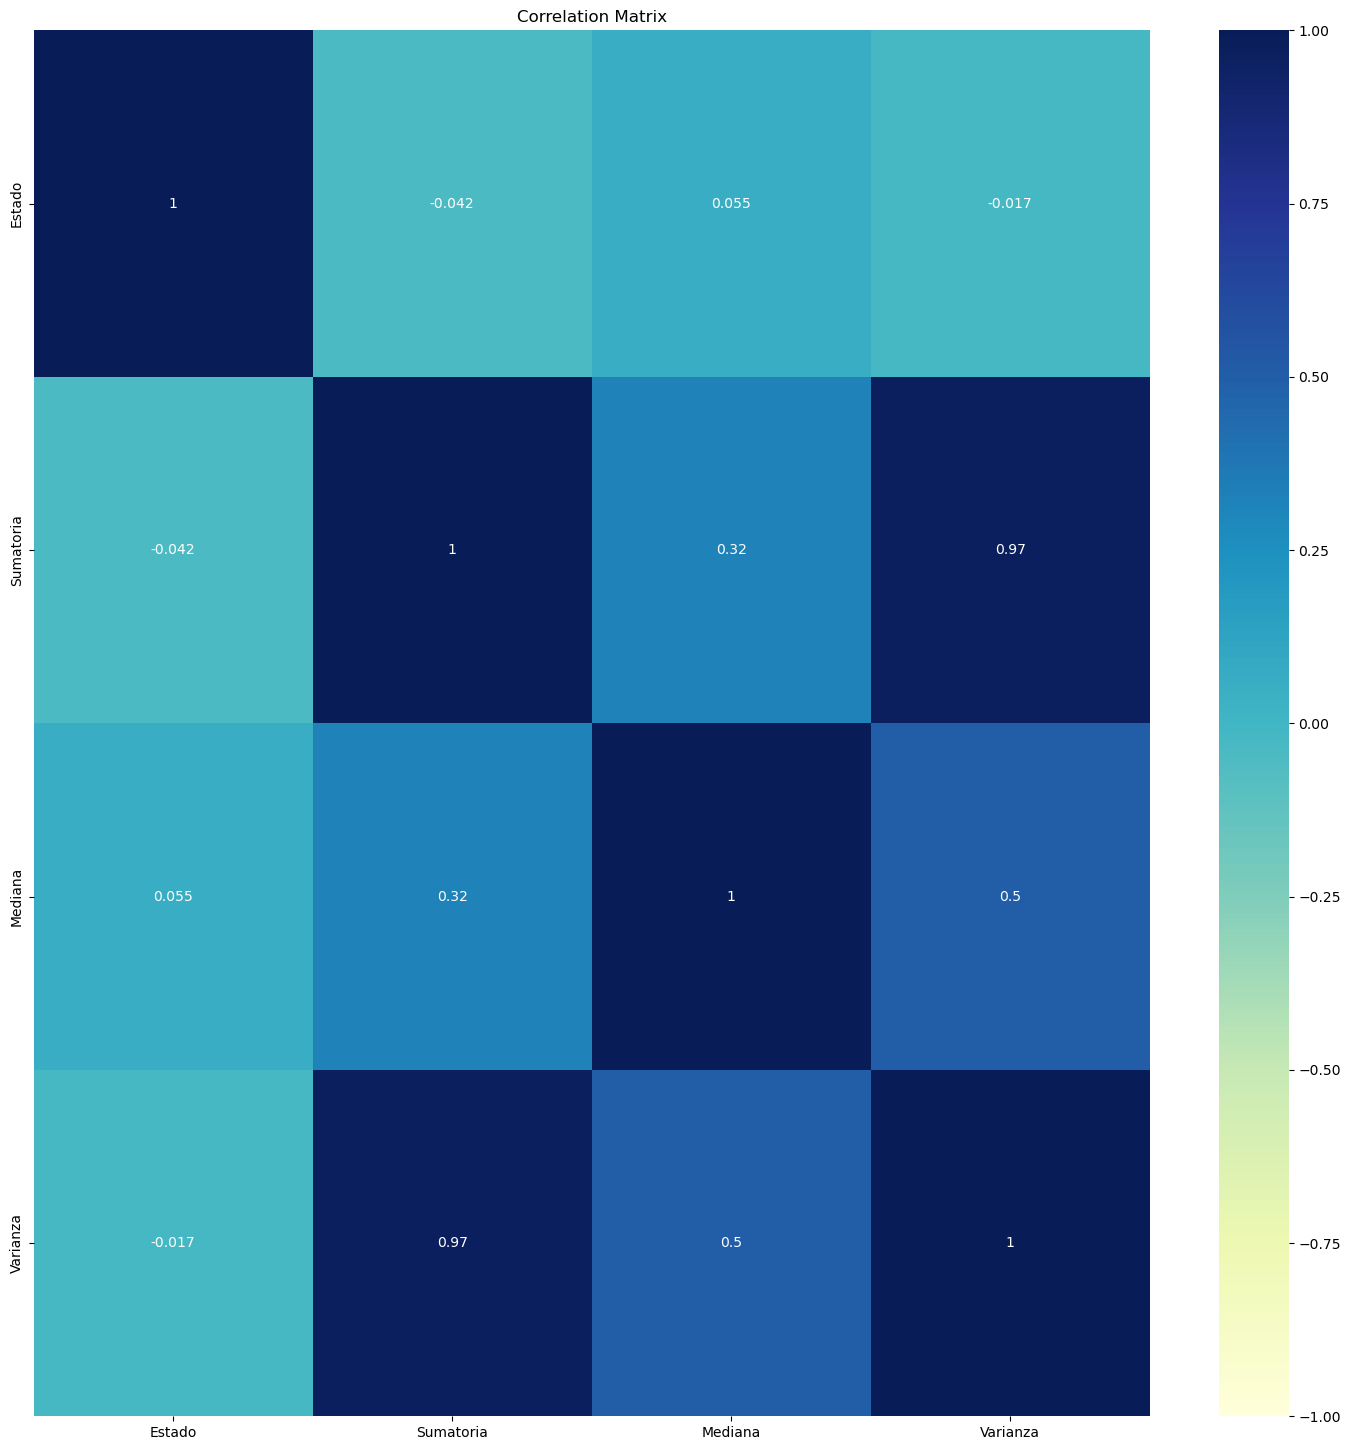

In [73]:
corr_matrix = d2.corr()
plt.figure(figsize=(18,18))
sns.heatmap(corr_matrix, annot = True, vmin = -1, vmax = 1, cmap = "YlGnBu").set_title('Correlation Matrix')
plt.show()

In [26]:
target_corr_df = pd.DataFrame(corr_matrix["Estado"].sort_values(ascending=False))
target_corr_df 

,Estado
Estado,1.000000
Mediana,0.054825
Varianza,-0.016609
Sumatoria,-0.042180


En este caso podemos observar que el estado va relacionado mayormente con la mediana que en el caso de la varianza o la suma, con esto en mente priorizaremos este parámetro para la generación de las redes neuronales

# 1. Ciclos normales y ciclos crepitantes

## Entrenamiento

In [79]:
d=pd.concat([d2[d2["Estado"]==0],d2[d2["Estado"]==1][:len(d2[d2["Estado"]==0])]])
x=d.drop(["Estado"],axis=1)
y=d.Estado.values
test_size = 0.3
val_size  = test_size/(1-test_size) # Elementos de validación


print (x.shape, y.shape)
print ("test size %.2f"%test_size)
print ("val size is %.2f (relative to %.2f) "%(val_size, 1-test_size))

Xtv, Xts, ytv, yts = train_test_split(x, y, test_size=test_size,stratify=y,random_state=23)

print (Xtv.shape, Xts.shape)

(3262, 3) (3262,)
test size 0.30
val size is 0.43 (relative to 0.70) 
(2283, 3) (979, 3)


In [37]:
from itertools import product
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    fig=plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [38]:
def tuple_generator(start, end):
        for i in range(start, end + 1):
            yield (i, i, i)

In [39]:
def optimizador(Xtv,ytv,Xts,yts,start=1,end=20):
    best=0
    best_a=0
    def tuple_generator1(start, end):
        for i in range(start, end + 1):
            yield (i, i, i)
    iter=list(tuple_generator1(start,end))
    for n in iter:
        mlp_relu = MLPClassifier(hidden_layer_sizes=n, activation='relu', solver='adam', max_iter=10000) 
        mlp_identity = MLPClassifier(hidden_layer_sizes=n, activation='identity', solver='adam', max_iter=10000) 
        mlp_tanh = MLPClassifier(hidden_layer_sizes=n, activation='tanh', solver='adam', max_iter=10000)
        mlp_logic=MLPClassifier(hidden_layer_sizes=n, activation='logistic', solver='adam', max_iter=10000)
        a=[mlp_relu,mlp_identity,mlp_tanh,mlp_logic]
        for n in a:
            n.fit(Xtv,ytv)
            acc=accuracy_score(yts,n.predict(Xts))
            if best_a<acc:
                best_a=acc
                best=n
    return best
        

In [40]:
def metrics(a,Xtv,ytv,Xts,yts,target_names):
    a.fit(Xtv,ytv)
    predict_train = a.predict(Xtv)
    predict_test = a.predict(Xts)
    print("Train ",a.activation)
    print("------------")
    print(classification_report(ytv,predict_train))
    mc_train = confusion_matrix(ytv,predict_train)
    plot_confusion_matrix(mc_train, classes=target_names,title='Confusion matrix train '+a.activation)
    print("------------")
    print("Test ",a.activation)
    print(classification_report(yts,predict_test))
    mc_train = confusion_matrix(yts,predict_test)
    plot_confusion_matrix(mc_train, classes=target_names,title='Confusion matrix test '+a.activation)

In [41]:
def tuple_generator1(start, end):
        for i in range(start, end + 1):
            yield (i, i, i)

In [42]:
def tuple_generator(start, end):
    return list(itertools.product(range(start, end+ 1), repeat=3))

In [43]:
def me_da_pereza(i,Xtv,ytv,Xts,yts,target_names):
    for a in i:
        metrics(a,Xtv,ytv,Xts,yts,target_names)

## Funciones de perdida para optimización

- Para problemas binarios usar Binary Cross-Entropy, para multicategoricos usar Categorical Cross-Entropy (CCE)

En este caso vamos a probar con varias redes neuronales, cambiaremos la activación para cambiar la arquitectura lo mismo que el solucionador de ser necesario, esto cambiara la forma del sigmoide, en el proceso se ira permutando los valores hasta encontrar un modelo más adecuado para la predicción 

## Resultados

## Lo que si se pidió

Train  relu
------------
              precision    recall  f1-score   support

           0       0.64      0.63      0.64      1142
           1       0.64      0.65      0.64      1141

    accuracy                           0.64      2283
   macro avg       0.64      0.64      0.64      2283
weighted avg       0.64      0.64      0.64      2283

Confusion matrix, without normalization
[[720 422]
 [400 741]]
------------
Test  relu
              precision    recall  f1-score   support

           0       0.62      0.62      0.62       489
           1       0.62      0.61      0.62       490

    accuracy                           0.62       979
   macro avg       0.62      0.62      0.62       979
weighted avg       0.62      0.62      0.62       979

Confusion matrix, without normalization
[[305 184]
 [190 300]]
Train  identity
------------
              precision    recall  f1-score   support

           0       0.63      0.38      0.47      1142
           1       0.55      0.77

c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1142
           1       0.50      1.00      0.67      1141

    accuracy                           0.50      2283
   macro avg       0.25      0.50      0.33      2283
weighted avg       0.25      0.50      0.33      2283

Confusion matrix, without normalization
[[   0 1142]
 [   0 1141]]
------------
Test  logistic
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       489
           1       0.50      1.00      0.67       490

    accuracy                           0.50       979
   macro avg       0.25      0.50      0.33       979
weighted avg       0.25      0.50      0.33       979

Confusion matrix, without normalization
[[  0 489]
 [  0 490]]


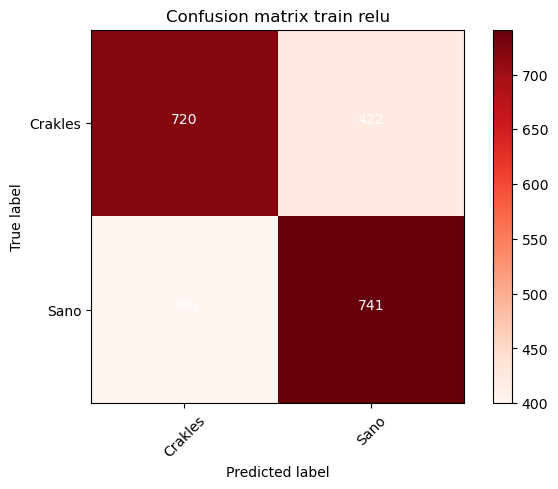

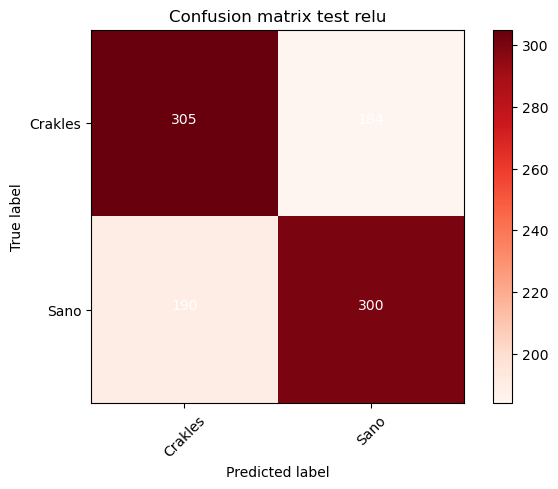

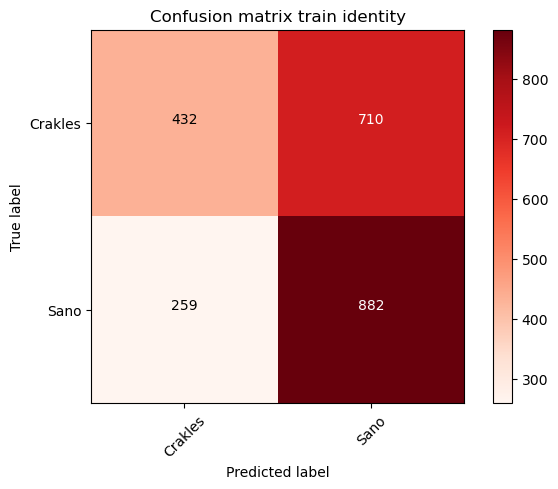

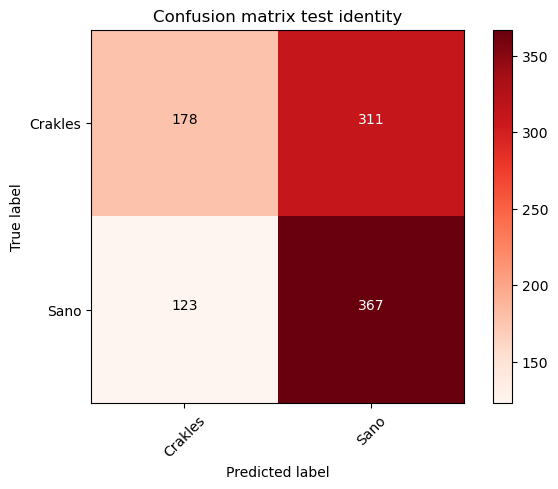

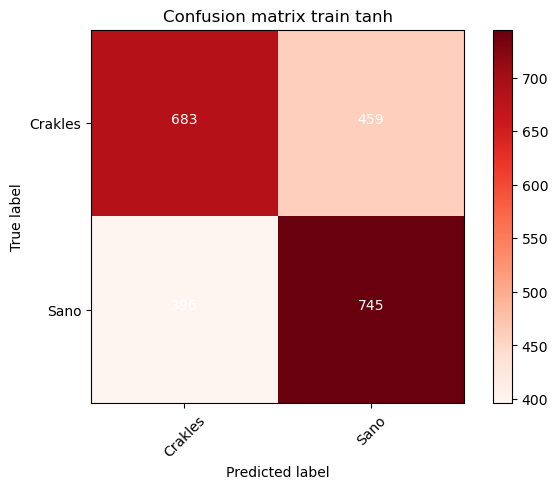

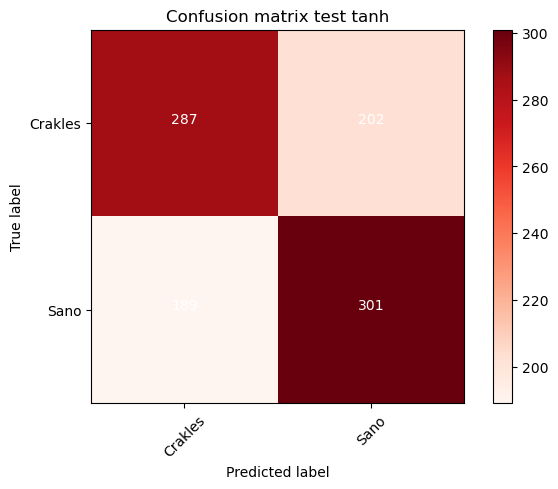

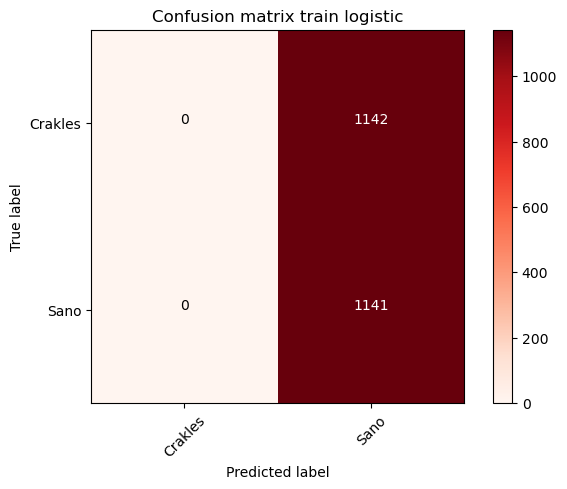

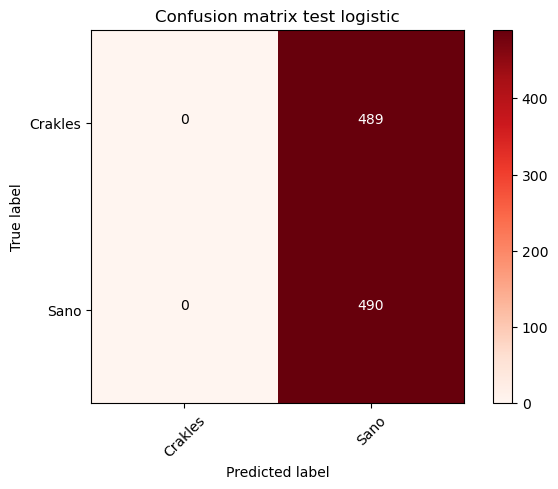

In [80]:
mlp_relu = MLPClassifier(hidden_layer_sizes=(20,20,20), activation='relu', solver='adam', max_iter=10000) 
mlp_identity = MLPClassifier(hidden_layer_sizes=(20,20,20), activation='identity', solver='adam', max_iter=10000) 
mlp_tanh = MLPClassifier(hidden_layer_sizes=(20,20,20), activation='tanh', solver='adam', max_iter=10000)
mlp_logic=MLPClassifier(hidden_layer_sizes=(20,20,20), activation='logistic', solver='adam', max_iter=10000)
a=[mlp_relu,mlp_identity,mlp_tanh,mlp_logic]
me_da_pereza(a,Xtv,ytv,Xts,yts,['Crakles','Sano'])

## Lo que no se pidió

In [81]:
#Se busca el mejor sigmoide con los mejores macro parametros en este caso con la función de acurracy
it=list(tuple_generator1(1,20))
activation=['relu','identity','tanh','logistic']
param_grid = {'hidden_layer_sizes': it,"activation":activation}
mlp= MLPClassifier(solver='adam', max_iter=10000)
grid_search = GridSearchCV(mlp, param_grid, cv=5,verbose=2,scoring="neg_log_loss")
grid_search.fit(Xtv, ytv)
best_params = grid_search.best_params_
best_score = grid_search.best_score_
#Se crea la mejor red neuronal posible con los parametros anteriores
best=MLPClassifier(hidden_layer_sizes=best_params["hidden_layer_sizes"], activation=best_params["activation"], solver='adam', max_iter=10000) 
#Se busca una pequeña optimización con respecto a esos macroparametros, en este caso usando como puntuación la funcion f1

Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV] END ......activation=relu, hidden_layer_sizes=(1, 1, 1); total time=   0.5s
[CV] END ......activation=relu, hidden_layer_sizes=(1, 1, 1); total time=   0.0s
[CV] END ......activation=relu, hidden_layer_sizes=(1, 1, 1); total time=   0.4s
[CV] END ......activation=relu, hidden_layer_sizes=(1, 1, 1); total time=   0.1s
[CV] END ......activation=relu, hidden_layer_sizes=(1, 1, 1); total time=   0.2s
[CV] END ......activation=relu, hidden_layer_sizes=(2, 2, 2); total time=   0.1s
[CV] END ......activation=relu, hidden_layer_sizes=(2, 2, 2); total time=   0.1s
[CV] END ......activation=relu, hidden_layer_sizes=(2, 2, 2); total time=   0.4s
[CV] END ......activation=relu, hidden_layer_sizes=(2, 2, 2); total time=   0.1s
[CV] END ......activation=relu, hidden_layer_sizes=(2, 2, 2); total time=   0.3s
[CV] END ......activation=relu, hidden_layer_sizes=(3, 3, 3); total time=   0.0s
[CV] END ......activation=relu, hidden_layer_si

Best Parameters: {'activation': 'relu', 'hidden_layer_sizes': (14, 14, 14)}
Best Score: -0.6537388636453838
Train  relu
------------
              precision    recall  f1-score   support

           0       0.64      0.67      0.65      1142
           1       0.65      0.62      0.63      1141

    accuracy                           0.64      2283
   macro avg       0.64      0.64      0.64      2283
weighted avg       0.64      0.64      0.64      2283

Confusion matrix, without normalization
[[766 376]
 [436 705]]
------------
Test  relu
              precision    recall  f1-score   support

           0       0.61      0.66      0.64       489
           1       0.63      0.59      0.61       490

    accuracy                           0.62       979
   macro avg       0.62      0.62      0.62       979
weighted avg       0.62      0.62      0.62       979

Confusion matrix, without normalization
[[322 167]
 [203 287]]


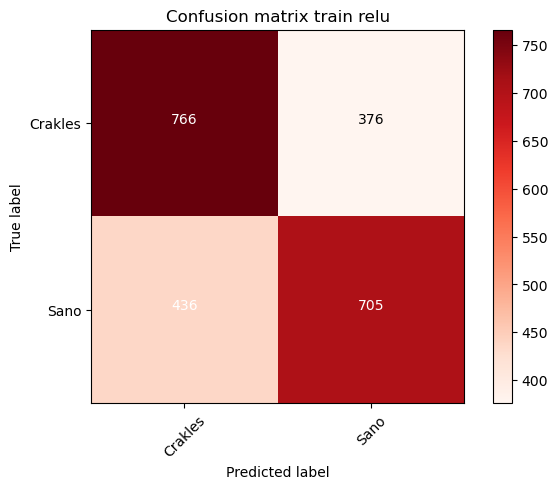

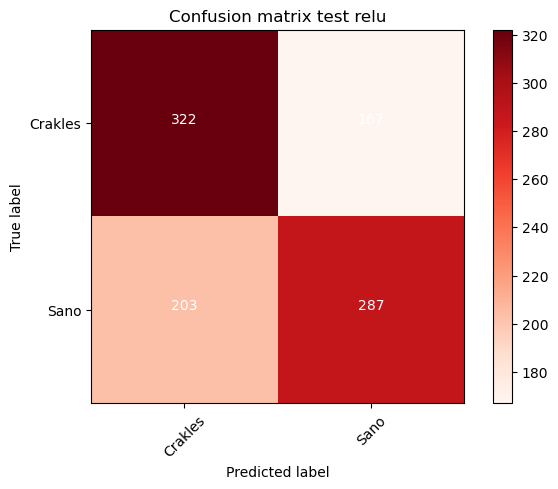

In [82]:
print("Best Parameters:", best_params)
print("Best Score:", best_score)
metrics(best,Xtv,ytv,Xts,yts,['Crakles','Sano'])

In [83]:
sem,_,_=best.hidden_layer_sizes
if sem>2:
    start=sem-2
    end=sem
else:
    start=sem
    end=sem+2
it=tuple_generator(start,end)
param_grid = {'hidden_layer_sizes': it}
grid_search = GridSearchCV(best, param_grid, cv=5,verbose=2,scoring="neg_log_loss")
grid_search.fit(Xtv, ytv)
best_params = grid_search.best_params_
best_score = grid_search.best_score_

#Se crea la mejor red neuronal posible con los parametros anteriores
the_bestest=MLPClassifier(hidden_layer_sizes=best_params["hidden_layer_sizes"], activation=best.activation, solver='adam', max_iter=10000) 

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END ....................hidden_layer_sizes=(12, 12, 12); total time=   1.4s
[CV] END ....................hidden_layer_sizes=(12, 12, 12); total time=   0.0s
[CV] END ....................hidden_layer_sizes=(12, 12, 12); total time=   0.0s
[CV] END ....................hidden_layer_sizes=(12, 12, 12); total time=   1.0s
[CV] END ....................hidden_layer_sizes=(12, 12, 12); total time=   0.0s
[CV] END ....................hidden_layer_sizes=(12, 12, 13); total time=   1.0s
[CV] END ....................hidden_layer_sizes=(12, 12, 13); total time=   0.0s
[CV] END ....................hidden_layer_sizes=(12, 12, 13); total time=   0.9s
[CV] END ....................hidden_layer_sizes=(12, 12, 13); total time=   1.1s
[CV] END ....................hidden_layer_sizes=(12, 12, 13); total time=   1.4s
[CV] END ....................hidden_layer_sizes=(12, 12, 14); total time=   1.4s
[CV] END ....................hidden_layer_sizes

Best Parameters: {'hidden_layer_sizes': (13, 13, 12)}
Best Score: -0.6537053140376751
Train  relu
------------
              precision    recall  f1-score   support

           0       0.64      0.69      0.66      1142
           1       0.66      0.60      0.63      1141

    accuracy                           0.65      2283
   macro avg       0.65      0.65      0.65      2283
weighted avg       0.65      0.65      0.65      2283

Confusion matrix, without normalization
[[789 353]
 [453 688]]
------------
Test  relu
              precision    recall  f1-score   support

           0       0.61      0.67      0.64       489
           1       0.64      0.57      0.60       490

    accuracy                           0.62       979
   macro avg       0.63      0.62      0.62       979
weighted avg       0.63      0.62      0.62       979

Confusion matrix, without normalization
[[330 159]
 [209 281]]


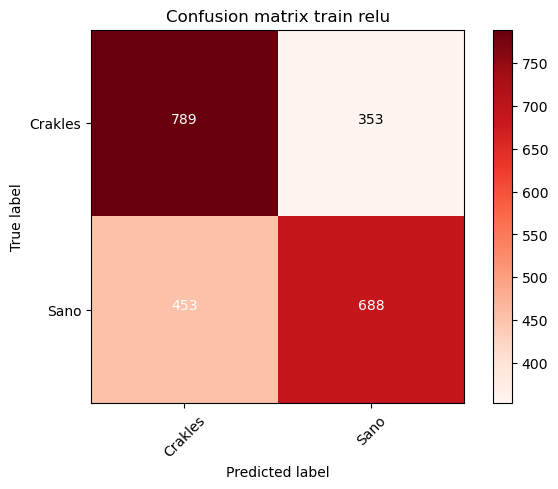

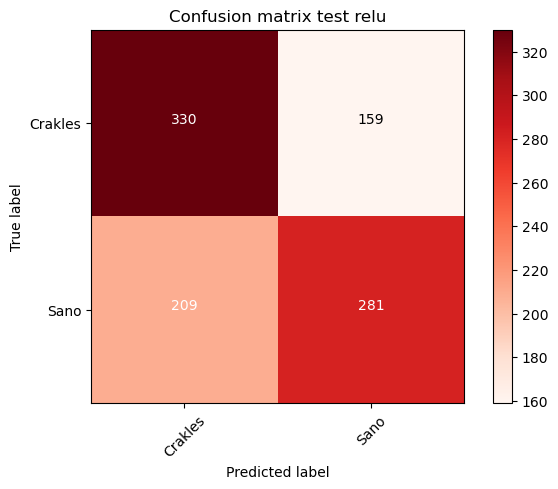

In [84]:
print("Best Parameters:", best_params)
print("Best Score:", best_score)
metrics(the_bestest,Xtv,ytv,Xts,yts,['Crakles','Sano'])

Pero que parámetros son mejores:

# 2. Ciclos normales y ciclos silbantes

## Lo que pide el trabajo:

(1310, 3) (1310,)
test size 0.30
val size is 0.43 (relative to 0.70) 
(917, 3) (393, 3)
Train  relu
------------
              precision    recall  f1-score   support

           1       0.58      0.77      0.66       459
           2       0.66      0.45      0.54       458

    accuracy                           0.61       917
   macro avg       0.62      0.61      0.60       917
weighted avg       0.62      0.61      0.60       917

Confusion matrix, without normalization
[[353 106]
 [251 207]]
------------
Test  relu
              precision    recall  f1-score   support

           1       0.58      0.80      0.68       196
           2       0.69      0.43      0.53       197

    accuracy                           0.62       393
   macro avg       0.63      0.62      0.60       393
weighted avg       0.63      0.62      0.60       393

Confusion matrix, without normalization
[[157  39]
 [112  85]]
Train  identity
------------
              precision    recall  f1-score   support


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\

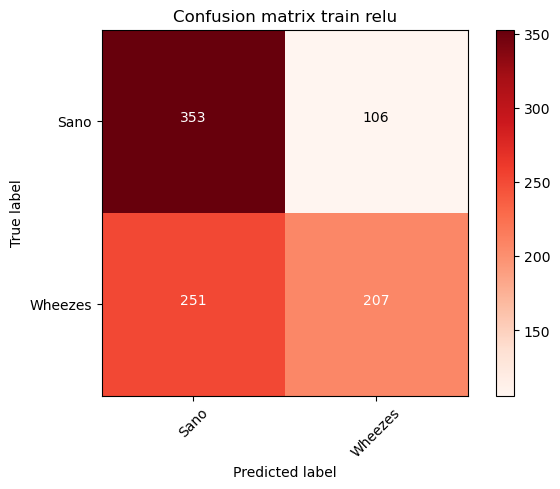

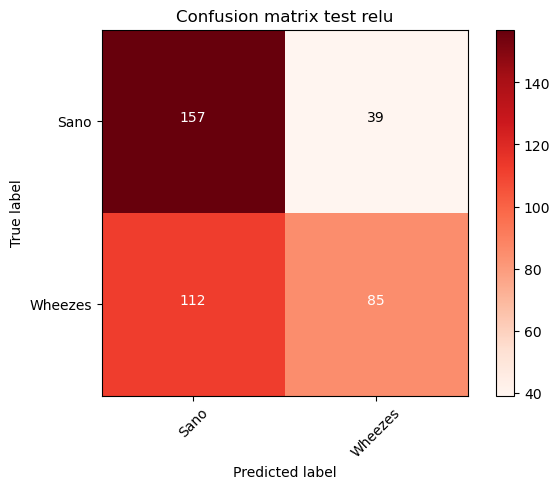

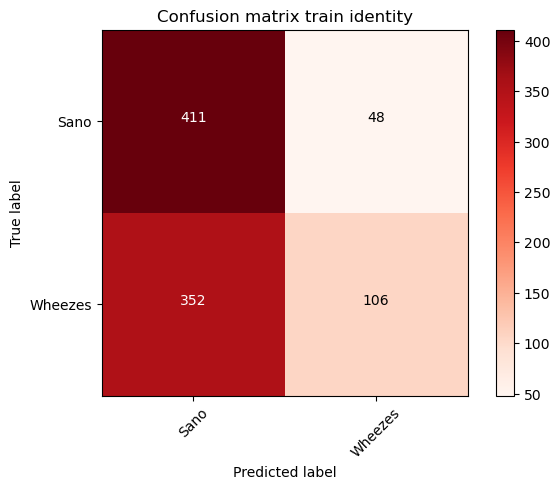

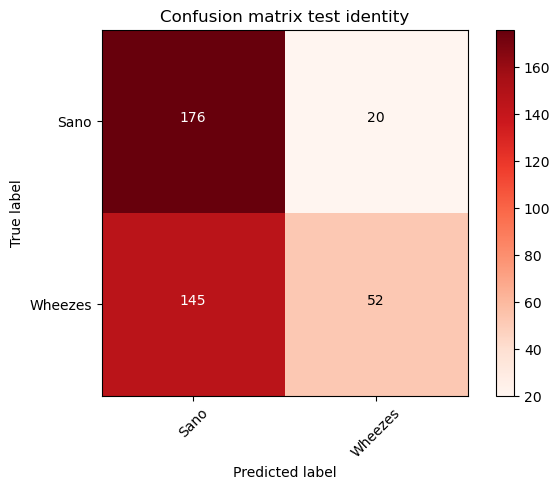

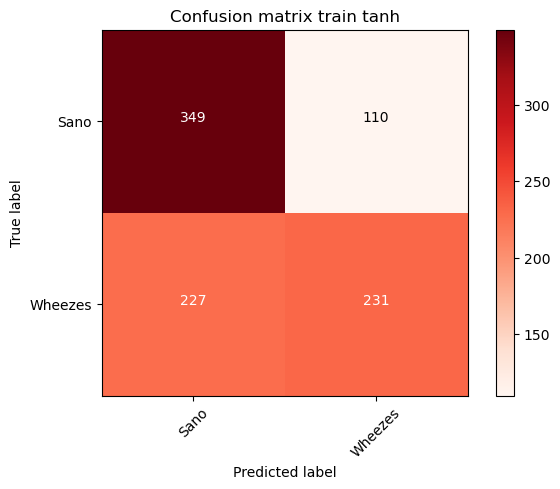

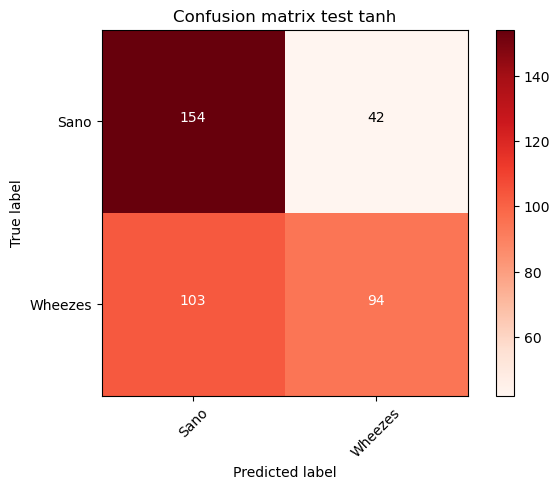

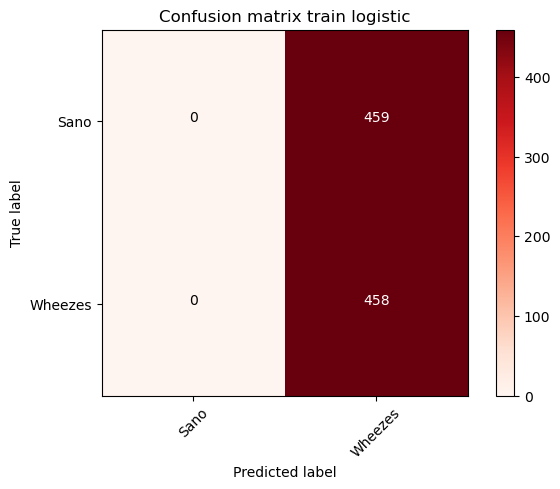

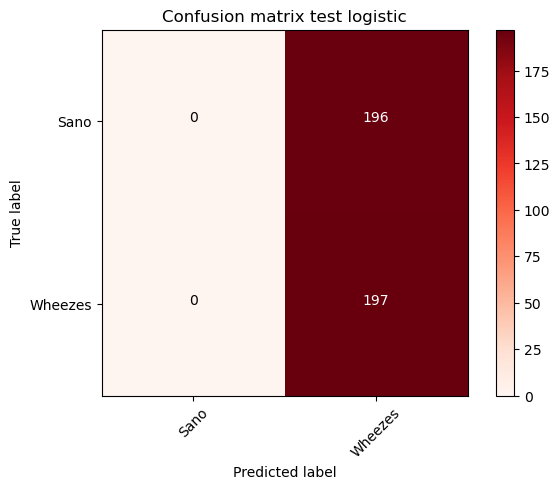

In [92]:
d=pd.concat([d2[d2["Estado"]==2],d2[d2["Estado"]==1][:len(d2[d2["Estado"]==2])]])
x=d.drop(["Estado"],axis=1)
y=d.Estado.values
test_size = 0.3
val_size  = test_size/(1-test_size) # Elementos de validación


print (x.shape, y.shape)
print ("test size %.2f"%test_size)
print ("val size is %.2f (relative to %.2f) "%(val_size, 1-test_size))

Xtv, Xts, ytv, yts = train_test_split(x, y, test_size=test_size,stratify=y,random_state=23)

print (Xtv.shape, Xts.shape)
mlp_relu = MLPClassifier(hidden_layer_sizes=(20,20,20), activation='relu', solver='adam', max_iter=10000) 
mlp_identity = MLPClassifier(hidden_layer_sizes=(20,20,20), activation='identity', solver='adam', max_iter=10000) 
mlp_tanh = MLPClassifier(hidden_layer_sizes=(20,20,20), activation='tanh', solver='adam', max_iter=10000)
mlp_logic=MLPClassifier(hidden_layer_sizes=(20,20,20), activation='logistic', solver='adam', max_iter=10000)
a=[mlp_relu,mlp_identity,mlp_tanh,mlp_logic]
me_da_pereza(a,Xtv,ytv,Xts,yts,['Sano','Wheezes'])

## La optimización porque no voy a perder lo que estudie en IA

In [97]:
#Se busca el mejor sigmoide con los mejores macro parametros en este caso con la función de acurracy
it=list(tuple_generator1(1,20))
activation=['relu','identity','tanh','logistic']
param_grid = {'hidden_layer_sizes': it,"activation":activation}
mlp= MLPClassifier(solver='adam', max_iter=10000)
grid_search = GridSearchCV(mlp, param_grid, cv=5,verbose=2,scoring="neg_log_loss")
grid_search.fit(Xtv, ytv)
best_params = grid_search.best_params_
best_score = grid_search.best_score_
#Se crea la mejor red neuronal posible con los parametros anteriores
best=MLPClassifier(hidden_layer_sizes=best_params["hidden_layer_sizes"], activation=best_params["activation"], solver='adam', max_iter=10000) 


Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV] END ......activation=relu, hidden_layer_sizes=(1, 1, 1); total time=   0.2s
[CV] END ......activation=relu, hidden_layer_sizes=(1, 1, 1); total time=   0.2s
[CV] END ......activation=relu, hidden_layer_sizes=(1, 1, 1); total time=   0.0s
[CV] END ......activation=relu, hidden_layer_sizes=(1, 1, 1); total time=   0.2s
[CV] END ......activation=relu, hidden_layer_sizes=(1, 1, 1); total time=   0.2s
[CV] END ......activation=relu, hidden_layer_sizes=(2, 2, 2); total time=   0.2s
[CV] END ......activation=relu, hidden_layer_sizes=(2, 2, 2); total time=   0.1s
[CV] END ......activation=relu, hidden_layer_sizes=(2, 2, 2); total time=   0.0s
[CV] END ......activation=relu, hidden_layer_sizes=(2, 2, 2); total time=   0.0s
[CV] END ......activation=relu, hidden_layer_sizes=(2, 2, 2); total time=   0.4s
[CV] END ......activation=relu, hidden_layer_sizes=(3, 3, 3); total time=   0.0s
[CV] END ......activation=relu, hidden_layer_si

Best Parameters: {'activation': 'identity', 'hidden_layer_sizes': (16, 16, 16)}
Best Score: 0.6788381556149102
Train  identity
------------
              precision    recall  f1-score   support

           1       0.54      0.89      0.67       459
           2       0.69      0.24      0.36       458

    accuracy                           0.57       917
   macro avg       0.62      0.57      0.52       917
weighted avg       0.62      0.57      0.52       917

Confusion matrix, without normalization
[[410  49]
 [348 110]]
------------
Test  identity
              precision    recall  f1-score   support

           1       0.55      0.89      0.68       196
           2       0.72      0.28      0.40       197

    accuracy                           0.59       393
   macro avg       0.64      0.59      0.54       393
weighted avg       0.64      0.59      0.54       393

Confusion matrix, without normalization
[[175  21]
 [142  55]]
MLPClassifier(activation='identity', hidden_layer_si

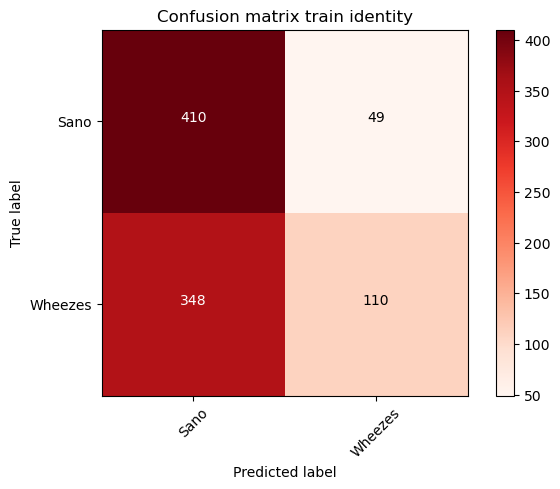

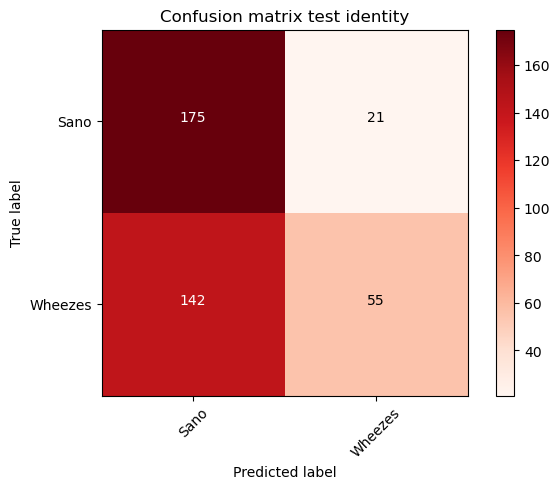

In [94]:
print("Best Parameters:", best_params)
print("Best Score:", best_score)
metrics(best,Xtv,ytv,Xts,yts,['Sano','Wheezes'])
print(best)

In [95]:
#Se busca una pequeña optimización con respecto a esos macroparametros, en este caso usando como puntuación la funcion f1
sem,_,_=best.hidden_layer_sizes
if sem>2:
    start=sem-2
    end=sem
else:
    start=sem
    end=sem+2
it=tuple_generator(start,end)
param_grid = {'hidden_layer_sizes': it}
grid_search = GridSearchCV(best, param_grid, cv=5,verbose=2,scoring="neg_log_loss")
grid_search.fit(Xtv, ytv)
best_params = grid_search.best_params_
best_score = grid_search.best_score_

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END ....................hidden_layer_sizes=(14, 14, 14); total time=   0.0s
[CV] END ....................hidden_layer_sizes=(14, 14, 14); total time=   0.0s
[CV] END ....................hidden_layer_sizes=(14, 14, 14); total time=   0.0s
[CV] END ....................hidden_layer_sizes=(14, 14, 14); total time=   0.0s
[CV] END ....................hidden_layer_sizes=(14, 14, 14); total time=   0.0s
[CV] END ....................hidden_layer_sizes=(14, 14, 15); total time=   0.0s
[CV] END ....................hidden_layer_sizes=(14, 14, 15); total time=   0.0s
[CV] END ....................hidden_layer_sizes=(14, 14, 15); total time=   0.0s
[CV] END ....................hidden_layer_sizes=(14, 14, 15); total time=   0.0s
[CV] END ....................hidden_layer_sizes=(14, 14, 15); total time=   0.0s
[CV] END ....................hidden_layer_sizes=(14, 14, 16); total time=   0.0s
[CV] END ....................hidden_layer_sizes

Best Parameters: {'activation': 'tanh', 'hidden_layer_sizes': (19, 19, 19)}
Best Score: -0.6648227780872034
Train  tanh
------------
              precision    recall  f1-score   support

           1       0.55      0.88      0.68       459
           2       0.70      0.29      0.41       458

    accuracy                           0.58       917
   macro avg       0.63      0.58      0.54       917
weighted avg       0.63      0.58      0.54       917

Confusion matrix, without normalization
[[402  57]
 [326 132]]
------------
Test  tanh
              precision    recall  f1-score   support

           1       0.56      0.87      0.68       196
           2       0.71      0.32      0.44       197

    accuracy                           0.59       393
   macro avg       0.63      0.59      0.56       393
weighted avg       0.63      0.59      0.56       393

Confusion matrix, without normalization
[[170  26]
 [134  63]]


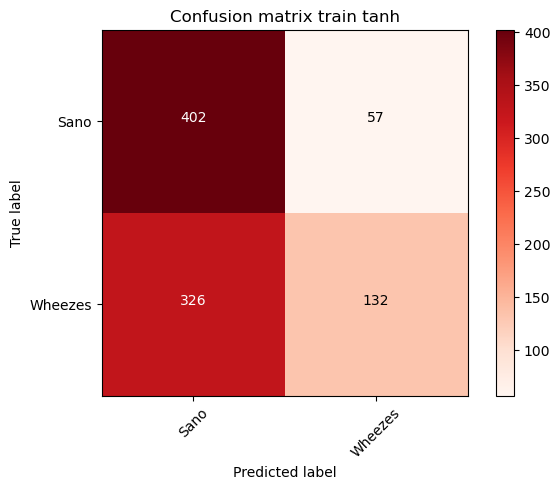

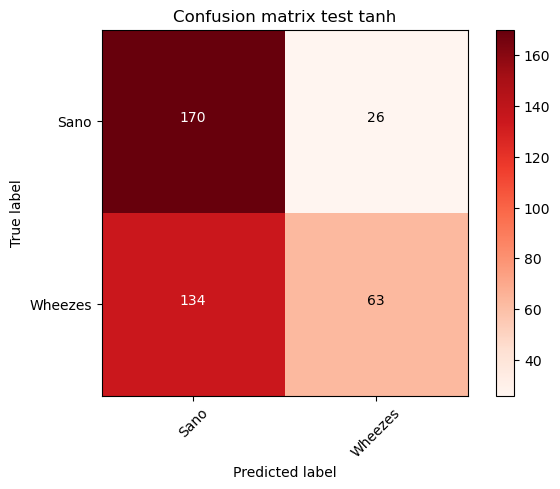

In [98]:
print("Best Parameters:", best_params)
print("Best Score:", best_score)
#Se crea la mejor red neuronal posible con los parametros anteriores
the_bestest=MLPClassifier(hidden_layer_sizes=best_params["hidden_layer_sizes"], activation=best.activation, solver='adam', max_iter=10000) 
metrics(the_bestest,Xtv,ytv,Xts,yts,['Sano','Wheezes'])

## 3. Silibantes y crepitantes

## Lo que si 

(1310, 3) (1310,)
test size 0.30
val size is 0.43 (relative to 0.70) 
(917, 3) (393, 3)
Train  relu
------------
              precision    recall  f1-score   support

           0       0.56      0.29      0.38       459
           1       0.52      0.77      0.62       458

    accuracy                           0.53       917
   macro avg       0.54      0.53      0.50       917
weighted avg       0.54      0.53      0.50       917

Confusion matrix, without normalization
[[133 326]
 [106 352]]
------------
Test  relu
              precision    recall  f1-score   support

           0       0.51      0.29      0.37       196
           1       0.51      0.73      0.60       197

    accuracy                           0.51       393
   macro avg       0.51      0.51      0.48       393
weighted avg       0.51      0.51      0.48       393

Confusion matrix, without normalization
[[ 56 140]
 [ 53 144]]
Train  identity
------------
              precision    recall  f1-score   support


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\

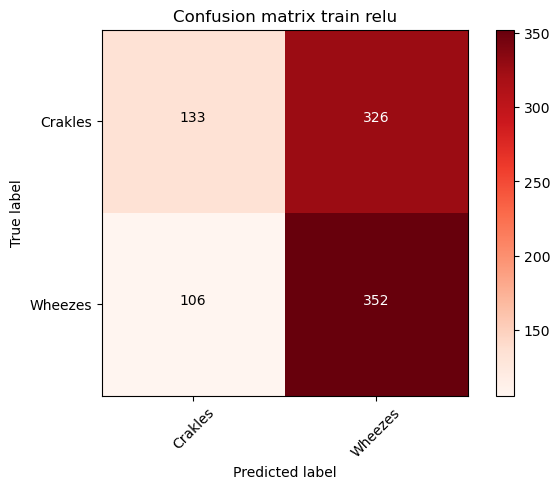

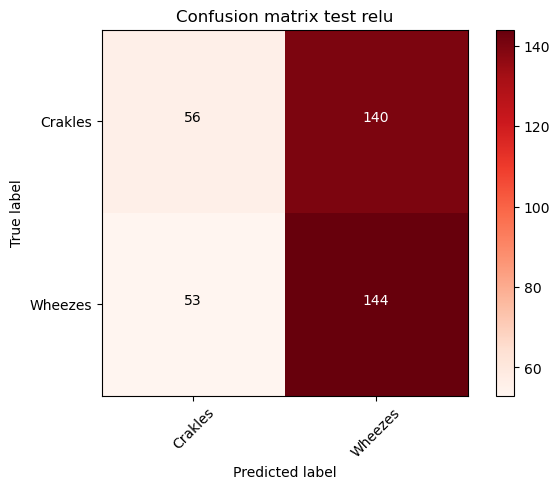

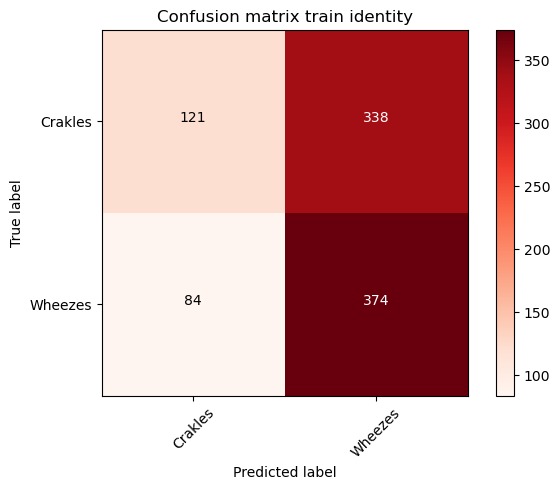

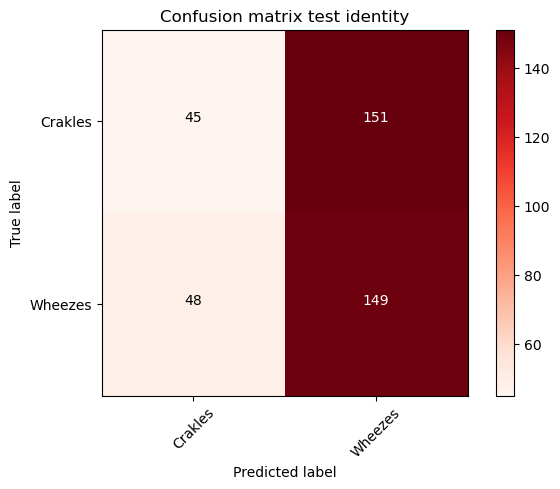

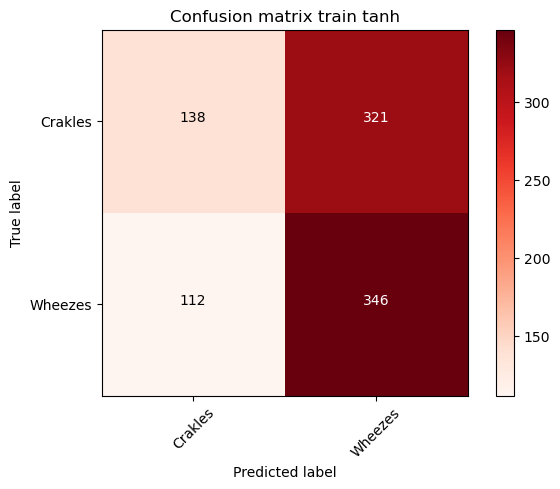

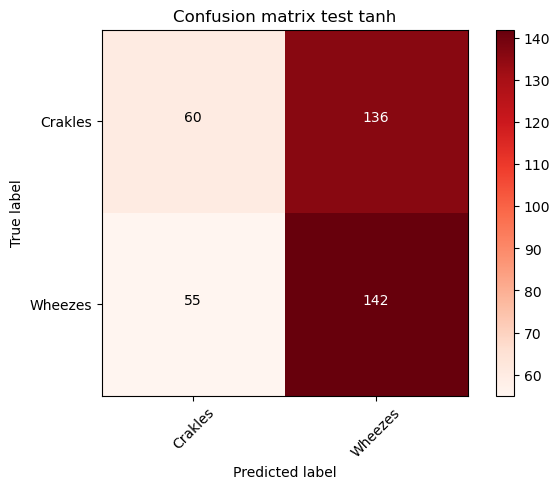

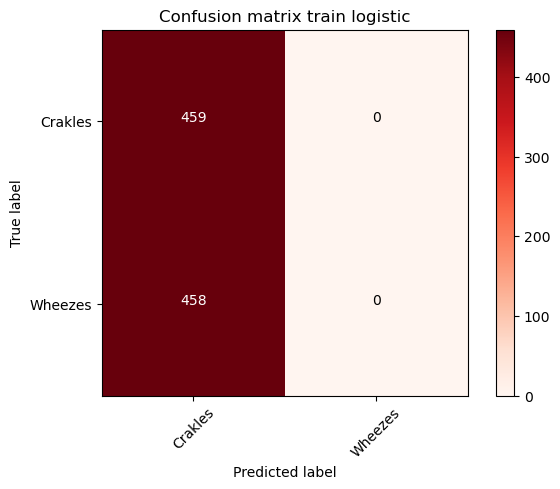

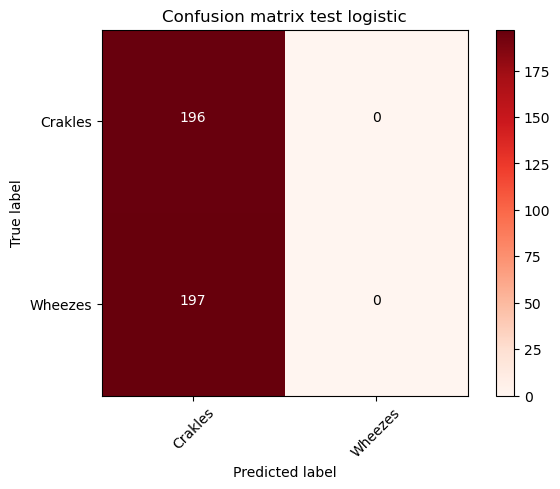

In [101]:

d=pd.concat([d2[d2["Estado"]==2],d2[d2["Estado"]==0][:len(d2[d2["Estado"]==2])]])
x=d.drop(["Estado"],axis=1)
y=d.Estado.values
np.putmask(y,y == 2,1)
test_size = 0.3
val_size  = test_size/(1-test_size) # Elementos de validación


print (x.shape, y.shape)
print ("test size %.2f"%test_size)
print ("val size is %.2f (relative to %.2f) "%(val_size, 1-test_size))

Xtv, Xts, ytv, yts = train_test_split(x, y, test_size=test_size,stratify=y,random_state=23)

print (Xtv.shape, Xts.shape)
mlp_relu = MLPClassifier(hidden_layer_sizes=(20,20,20), activation='relu', solver='adam', max_iter=10000) 
mlp_identity = MLPClassifier(hidden_layer_sizes=(20,20,20), activation='identity', solver='adam', max_iter=10000) 
mlp_tanh = MLPClassifier(hidden_layer_sizes=(20,20,20), activation='tanh', solver='adam', max_iter=10000)
mlp_logic=MLPClassifier(hidden_layer_sizes=(20,20,20), activation='logistic', solver='adam', max_iter=10000)
a=[mlp_relu,mlp_identity,mlp_tanh,mlp_logic]
me_da_pereza(a,Xtv,ytv,Xts,yts,['Crakles','Wheezes'])

## Lo que espero que nos den más nota:

In [102]:
#Se busca el mejor sigmoide con los mejores macro parametros en este caso con la función de acurracy
it=list(tuple_generator1(1,20))
activation=['relu','identity','tanh','logistic']
param_grid = {'hidden_layer_sizes': it,"activation":activation}
mlp= MLPClassifier(solver='adam', max_iter=10000)
grid_search = GridSearchCV(mlp, param_grid, cv=5,verbose=2,scoring="neg_log_loss")
grid_search.fit(Xtv, ytv)
best_params = grid_search.best_params_
best_score = grid_search.best_score_
#Se crea la mejor red neuronal posible con los parametros anteriores
best=MLPClassifier(hidden_layer_sizes=best_params["hidden_layer_sizes"], activation=best_params["activation"], solver='adam', max_iter=10000) 

Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV] END ......activation=relu, hidden_layer_sizes=(1, 1, 1); total time=   0.2s
[CV] END ......activation=relu, hidden_layer_sizes=(1, 1, 1); total time=   0.0s
[CV] END ......activation=relu, hidden_layer_sizes=(1, 1, 1); total time=   0.0s
[CV] END ......activation=relu, hidden_layer_sizes=(1, 1, 1); total time=   0.0s
[CV] END ......activation=relu, hidden_layer_sizes=(1, 1, 1); total time=   0.0s
[CV] END ......activation=relu, hidden_layer_sizes=(2, 2, 2); total time=   0.0s
[CV] END ......activation=relu, hidden_layer_sizes=(2, 2, 2); total time=   0.0s
[CV] END ......activation=relu, hidden_layer_sizes=(2, 2, 2); total time=   0.2s
[CV] END ......activation=relu, hidden_layer_sizes=(2, 2, 2); total time=   0.0s
[CV] END ......activation=relu, hidden_layer_sizes=(2, 2, 2); total time=   0.0s
[CV] END ......activation=relu, hidden_layer_sizes=(3, 3, 3); total time=   0.3s
[CV] END ......activation=relu, hidden_layer_si

Best Parameters: {'activation': 'tanh', 'hidden_layer_sizes': (6, 6, 6)}
Best Score: -0.6892922832511136
Train  tanh
------------
              precision    recall  f1-score   support

           0       0.48      0.86      0.62       459
           1       0.37      0.09      0.14       458

    accuracy                           0.47       917
   macro avg       0.43      0.47      0.38       917
weighted avg       0.43      0.47      0.38       917

Confusion matrix, without normalization
[[393  66]
 [419  39]]
------------
Test  tanh
              precision    recall  f1-score   support

           0       0.50      0.90      0.65       196
           1       0.55      0.12      0.19       197

    accuracy                           0.51       393
   macro avg       0.53      0.51      0.42       393
weighted avg       0.53      0.51      0.42       393

Confusion matrix, without normalization
[[177  19]
 [174  23]]
MLPClassifier(activation='tanh', hidden_layer_sizes=(6, 6, 6), max

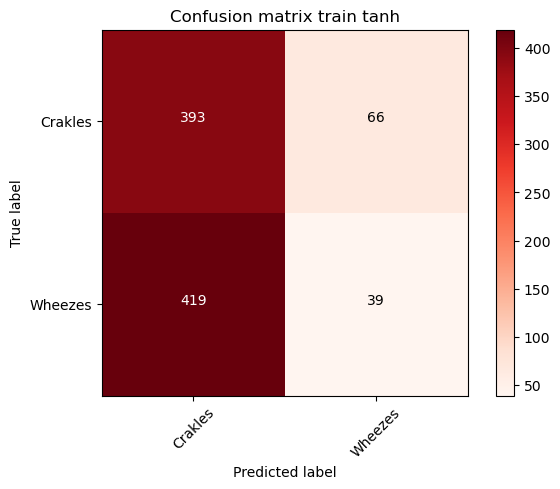

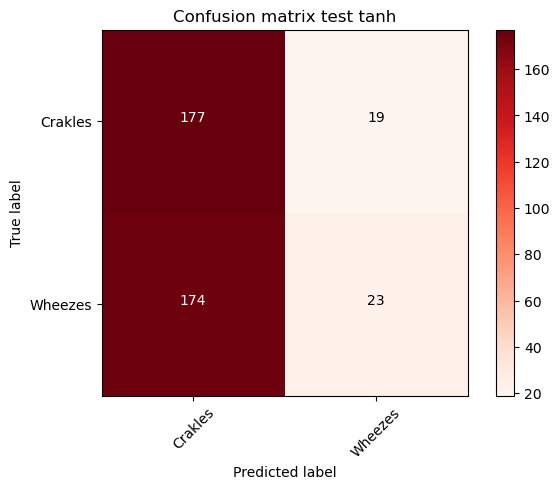

In [103]:
print("Best Parameters:", best_params)
print("Best Score:", best_score)
metrics(best,Xtv,ytv,Xts,yts,['Crakles','Wheezes'])
print(best)

In [104]:
#Se busca una pequeña optimización con respecto a esos macroparametros, en este caso usando como puntuación la funcion f1
sem,_,_=best.hidden_layer_sizes
if sem>2:
    start=sem-2
    end=sem
else:
    start=sem
    end=sem+2
it=tuple_generator(start,end)
param_grid = {'hidden_layer_sizes': it}
grid_search = GridSearchCV(best, param_grid, cv=5,verbose=2,scoring="neg_log_loss")
grid_search.fit(Xtv, ytv)
best_params = grid_search.best_params_
best_score = grid_search.best_score_

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END .......................hidden_layer_sizes=(4, 4, 4); total time=   0.0s
[CV] END .......................hidden_layer_sizes=(4, 4, 4); total time=   0.0s
[CV] END .......................hidden_layer_sizes=(4, 4, 4); total time=   0.0s
[CV] END .......................hidden_layer_sizes=(4, 4, 4); total time=   0.0s
[CV] END .......................hidden_layer_sizes=(4, 4, 4); total time=   0.0s
[CV] END .......................hidden_layer_sizes=(4, 4, 5); total time=   0.0s
[CV] END .......................hidden_layer_sizes=(4, 4, 5); total time=   0.0s
[CV] END .......................hidden_layer_sizes=(4, 4, 5); total time=   0.0s
[CV] END .......................hidden_layer_sizes=(4, 4, 5); total time=   0.0s
[CV] END .......................hidden_layer_sizes=(4, 4, 5); total time=   0.0s
[CV] END .......................hidden_layer_sizes=(4, 4, 6); total time=   0.0s
[CV] END .......................hidden_layer_si

Best Parameters: {'hidden_layer_sizes': (6, 5, 4)}
Best Score: -0.6907757242492171
Train  tanh
------------
              precision    recall  f1-score   support

           0       0.55      0.29      0.38       459
           1       0.52      0.76      0.62       458

    accuracy                           0.53       917
   macro avg       0.54      0.53      0.50       917
weighted avg       0.54      0.53      0.50       917

Confusion matrix, without normalization
[[135 324]
 [109 349]]
------------
Test  tanh
              precision    recall  f1-score   support

           0       0.50      0.29      0.36       196
           1       0.50      0.72      0.59       197

    accuracy                           0.50       393
   macro avg       0.50      0.50      0.48       393
weighted avg       0.50      0.50      0.48       393

Confusion matrix, without normalization
[[ 56 140]
 [ 55 142]]


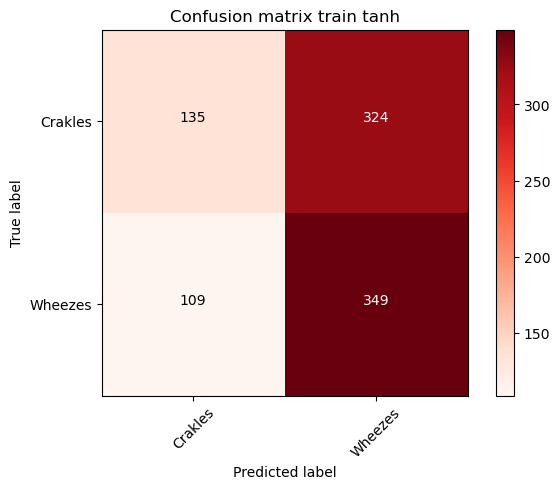

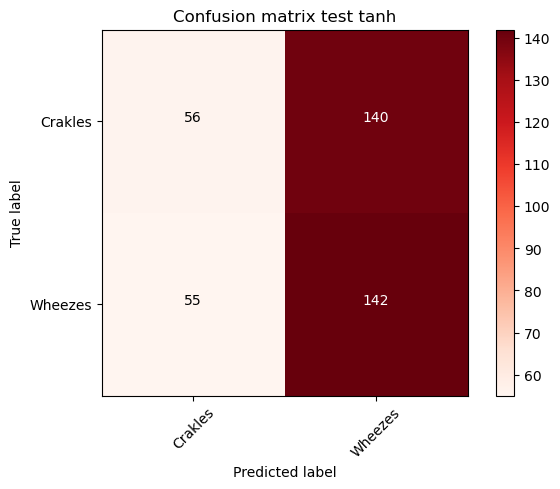

In [105]:
print("Best Parameters:", best_params)
print("Best Score:", best_score)
#Se crea la mejor red neuronal posible con los parametros anteriores
the_bestest=MLPClassifier(hidden_layer_sizes=best_params["hidden_layer_sizes"], activation=best.activation, solver='adam', max_iter=10000) 
metrics(the_bestest,Xtv,ytv,Xts,yts,['Crakles','Wheezes'])

# 4. Normales, silibantes y crepitantes

## Franklin perdón si llegas hasta aquí

(2619, 3) (2619,)
test size 0.30
val size is 0.43 (relative to 0.70) 
(1833, 3) (786, 3)
Train  relu
------------
              precision    recall  f1-score   support

           0       0.50      0.64      0.56       687
           1       0.52      0.72      0.60       687
           2       0.00      0.00      0.00       459

    accuracy                           0.51      1833
   macro avg       0.34      0.45      0.39      1833
weighted avg       0.38      0.51      0.44      1833

Confusion matrix, without normalization
[[440 247   0]
 [195 492   0]
 [244 215   0]]
------------
Test  relu
              precision    recall  f1-score   support

           0       0.51      0.63      0.56       295
           1       0.49      0.69      0.57       295
           2       0.00      0.00      0.00       196

    accuracy                           0.50       786
   macro avg       0.33      0.44      0.38       786
weighted avg       0.37      0.50      0.43       786

Confusion matr

c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\

Train  identity
------------
              precision    recall  f1-score   support

           0       0.49      0.40      0.44       687
           1       0.44      0.81      0.57       687
           2       0.00      0.00      0.00       459

    accuracy                           0.45      1833
   macro avg       0.31      0.40      0.34      1833
weighted avg       0.35      0.45      0.38      1833

Confusion matrix, without normalization
[[272 415   0]
 [128 559   0]
 [154 305   0]]
------------
Test  identity
              precision    recall  f1-score   support

           0       0.51      0.38      0.43       295
           1       0.42      0.81      0.56       295
           2       0.00      0.00      0.00       196

    accuracy                           0.45       786
   macro avg       0.31      0.40      0.33       786
weighted avg       0.35      0.45      0.37       786

Confusion matrix, without normalization
[[112 183   0]
 [ 55 240   0]
 [ 53 143   0]]


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\

Train  tanh
------------
              precision    recall  f1-score   support

           0       0.50      0.65      0.56       687
           1       0.52      0.71      0.60       687
           2       0.00      0.00      0.00       459

    accuracy                           0.51      1833
   macro avg       0.34      0.45      0.39      1833
weighted avg       0.38      0.51      0.44      1833

Confusion matrix, without normalization
[[444 243   0]
 [200 487   0]
 [249 210   0]]
------------
Test  tanh
              precision    recall  f1-score   support

           0       0.51      0.63      0.56       295
           1       0.49      0.69      0.57       295
           2       0.00      0.00      0.00       196

    accuracy                           0.50       786
   macro avg       0.33      0.44      0.38       786
weighted avg       0.37      0.50      0.43       786

Confusion matrix, without normalization
[[187 108   0]
 [ 91 204   0]
 [ 92 104   0]]


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\

Train  logistic
------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       687
           1       0.37      1.00      0.55       687
           2       0.00      0.00      0.00       459

    accuracy                           0.37      1833
   macro avg       0.12      0.33      0.18      1833
weighted avg       0.14      0.37      0.20      1833

Confusion matrix, without normalization
[[  0 687   0]
 [  0 687   0]
 [  0 459   0]]
------------
Test  logistic
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       295
           1       0.38      1.00      0.55       295
           2       0.00      0.00      0.00       196

    accuracy                           0.38       786
   macro avg       0.13      0.33      0.18       786
weighted avg       0.14      0.38      0.20       786

Confusion matrix, without normalization
[[  0 295   0]
 [  0 295   0]
 [  0 196   0]]


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\

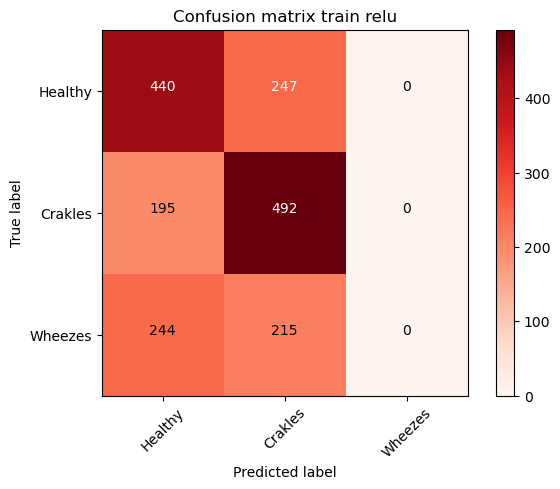

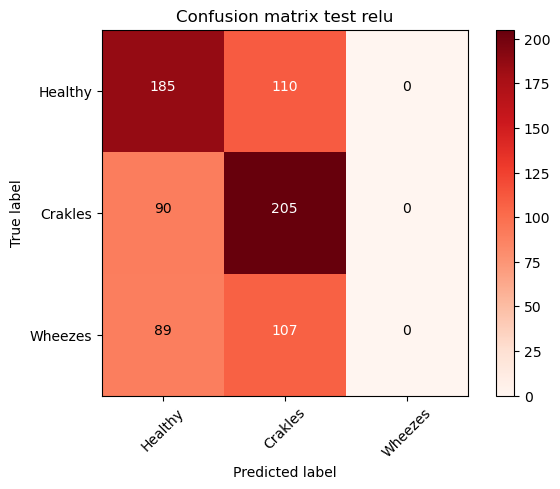

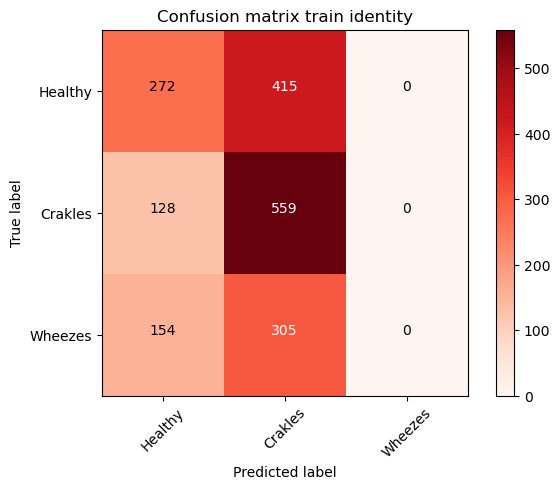

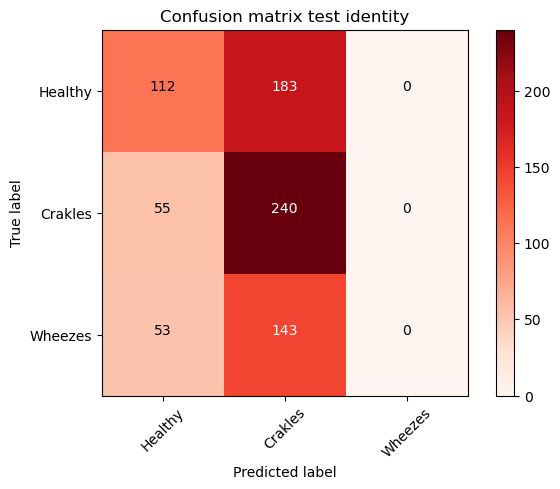

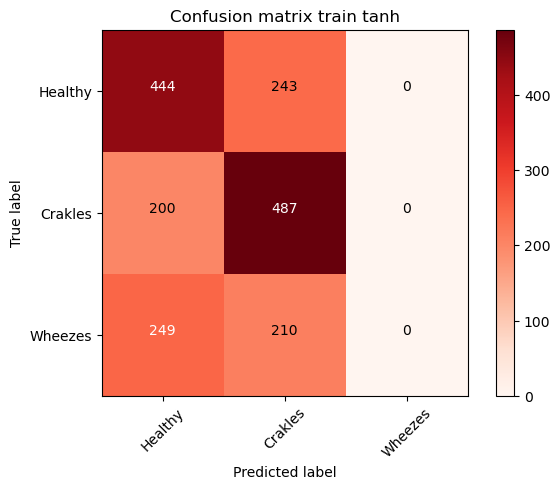

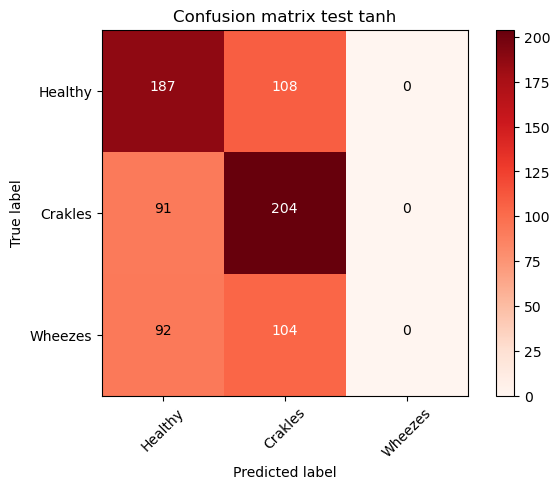

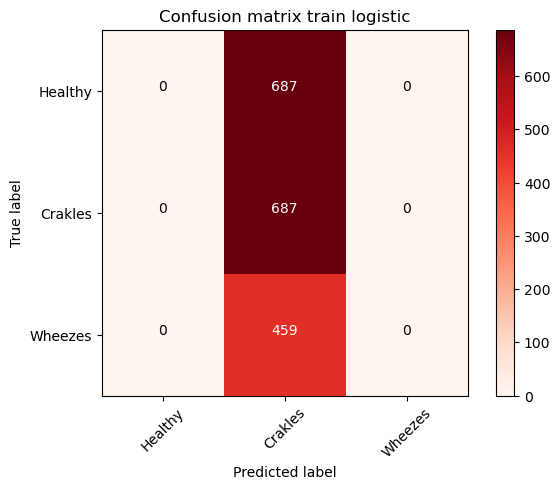

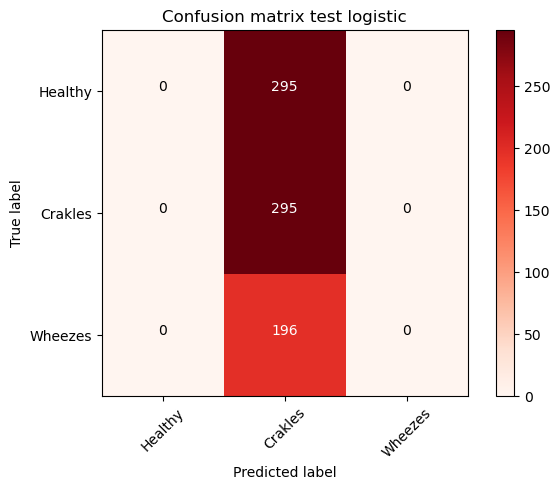

In [111]:

d=pd.concat([d2[d2["Estado"]==2],d2[d2["Estado"]==0][:int(len(d2[d2["Estado"]==2])*1.5)],d2[d2["Estado"]==1][:int(len(d2[d2["Estado"]==2])*1.5)] ])
x=d.drop(["Estado"],axis=1)
y=d.Estado.values
test_size = 0.3
val_size  = test_size/(1-test_size) # Elementos de validación


print (x.shape, y.shape)
print ("test size %.2f"%test_size)
print ("val size is %.2f (relative to %.2f) "%(val_size, 1-test_size))

Xtv, Xts, ytv, yts = train_test_split(x, y, test_size=test_size,stratify=y,random_state=23)

print (Xtv.shape, Xts.shape)
mlp_relu = MLPClassifier(hidden_layer_sizes=(20,20,20), activation='relu', solver='adam', max_iter=10000) 
mlp_identity = MLPClassifier(hidden_layer_sizes=(20,20,20), activation='identity', solver='adam', max_iter=10000) 
mlp_tanh = MLPClassifier(hidden_layer_sizes=(20,20,20), activation='tanh', solver='adam', max_iter=10000)
mlp_logic=MLPClassifier(hidden_layer_sizes=(20,20,20), activation='logistic', solver='adam', max_iter=10000)
a=[mlp_relu,mlp_identity,mlp_tanh,mlp_logic]
me_da_pereza(a,Xtv,ytv,Xts,yts,["Healthy",'Crakles','Wheezes'])

## Dormir esta sobrevalorado 

In [112]:
#Se busca el mejor sigmoide con los mejores macro parametros en este caso con la función de acurracy
it=list(tuple_generator1(1,20))
activation=['relu','identity','tanh','logistic']
param_grid = {'hidden_layer_sizes': it,"activation":activation}
mlp= MLPClassifier(solver='adam', max_iter=10000)
grid_search = GridSearchCV(mlp, param_grid, cv=5,verbose=2,scoring="neg_log_loss")
grid_search.fit(Xtv, ytv)
best_params = grid_search.best_params_
best_score = grid_search.best_score_
#Se crea la mejor red neuronal posible con los parametros anteriores
best=MLPClassifier(hidden_layer_sizes=best_params["hidden_layer_sizes"], activation=best_params["activation"], solver='adam', max_iter=10000) 

Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV] END ......activation=relu, hidden_layer_sizes=(1, 1, 1); total time=   0.0s
[CV] END ......activation=relu, hidden_layer_sizes=(1, 1, 1); total time=   0.2s
[CV] END ......activation=relu, hidden_layer_sizes=(1, 1, 1); total time=   0.0s
[CV] END ......activation=relu, hidden_layer_sizes=(1, 1, 1); total time=   0.0s
[CV] END ......activation=relu, hidden_layer_sizes=(1, 1, 1); total time=   0.1s
[CV] END ......activation=relu, hidden_layer_sizes=(2, 2, 2); total time=   0.1s
[CV] END ......activation=relu, hidden_layer_sizes=(2, 2, 2); total time=   0.3s
[CV] END ......activation=relu, hidden_layer_sizes=(2, 2, 2); total time=   0.2s
[CV] END ......activation=relu, hidden_layer_sizes=(2, 2, 2); total time=   0.2s
[CV] END ......activation=relu, hidden_layer_sizes=(2, 2, 2); total time=   0.0s
[CV] END ......activation=relu, hidden_layer_sizes=(3, 3, 3); total time=   0.0s
[CV] END ......activation=relu, hidden_layer_si

Best Parameters: {'hidden_layer_sizes': (18, 19, 19)}
Best Score: -1.0183628336294257
Train  relu
------------
              precision    recall  f1-score   support

           0       0.50      0.69      0.58       687
           1       0.54      0.69      0.61       687
           2       0.00      0.00      0.00       459

    accuracy                           0.52      1833
   macro avg       0.35      0.46      0.39      1833
weighted avg       0.39      0.52      0.44      1833

Confusion matrix, without normalization
[[476 211   0]
 [214 473   0]
 [268 191   0]]
------------
Test  relu
              precision    recall  f1-score   support

           0       0.49      0.69      0.58       295
           1       0.51      0.64      0.57       295
           2       0.00      0.00      0.00       196

    accuracy                           0.50       786
   macro avg       0.33      0.45      0.38       786
weighted avg       0.38      0.50      0.43       786

Confusion matrix,

c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\

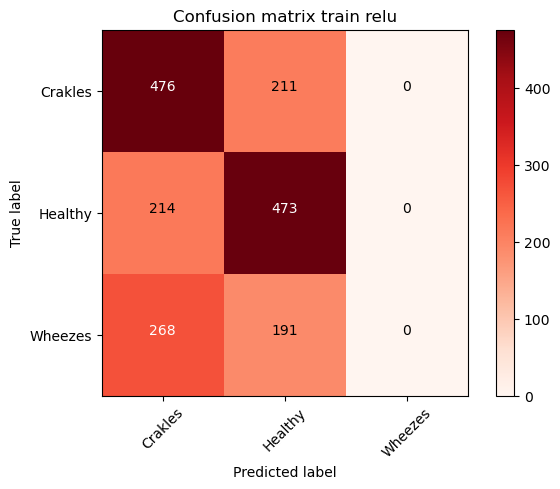

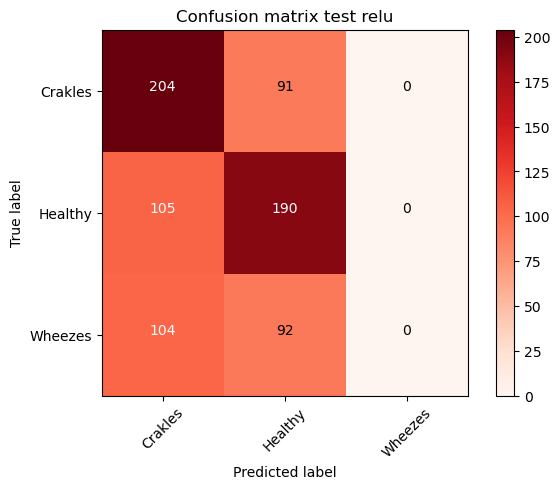

In [117]:
print("Best Parameters:", best_params)
print("Best Score:", best_score)
metrics(best,Xtv,ytv,Xts,yts,['Crakles',"Healthy",'Wheezes'])

In [114]:
#Se busca una pequeña optimización con respecto a esos macroparametros, en este caso usando como puntuación la funcion f1
sem,_,_=best.hidden_layer_sizes
if sem>2:
    start=sem-2
    end=sem
else:
    start=sem
    end=sem+2
it=tuple_generator(start,end)
param_grid = {'hidden_layer_sizes': it}
grid_search = GridSearchCV(best, param_grid, cv=5,verbose=2,scoring="neg_log_loss")
grid_search.fit(Xtv, ytv)
best_params = grid_search.best_params_
best_score = grid_search.best_score_

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END ....................hidden_layer_sizes=(18, 18, 18); total time=   1.1s
[CV] END ....................hidden_layer_sizes=(18, 18, 18); total time=   0.9s
[CV] END ....................hidden_layer_sizes=(18, 18, 18); total time=   1.2s
[CV] END ....................hidden_layer_sizes=(18, 18, 18); total time=   1.1s
[CV] END ....................hidden_layer_sizes=(18, 18, 18); total time=   0.6s
[CV] END ....................hidden_layer_sizes=(18, 18, 19); total time=   0.9s
[CV] END ....................hidden_layer_sizes=(18, 18, 19); total time=   0.9s
[CV] END ....................hidden_layer_sizes=(18, 18, 19); total time=   1.4s
[CV] END ....................hidden_layer_sizes=(18, 18, 19); total time=   0.0s
[CV] END ....................hidden_layer_sizes=(18, 18, 19); total time=   0.9s
[CV] END ....................hidden_layer_sizes=(18, 18, 20); total time=   0.7s
[CV] END ....................hidden_layer_sizes

Best Parameters: {'hidden_layer_sizes': (18, 19, 19)}
Best Score: -1.0183628336294257
Train  relu
------------
              precision    recall  f1-score   support

           0       0.50      0.61      0.55       687
           1       0.50      0.72      0.59       687
           2       0.20      0.00      0.01       459

    accuracy                           0.50      1833
   macro avg       0.40      0.45      0.38      1833
weighted avg       0.43      0.50      0.43      1833

Confusion matrix, without normalization
[[420 264   3]
 [186 496   5]
 [228 229   2]]
------------
Test  relu
              precision    recall  f1-score   support

           0       0.52      0.61      0.56       295
           1       0.48      0.71      0.57       295
           2       0.50      0.01      0.01       196

    accuracy                           0.50       786
   macro avg       0.50      0.44      0.38       786
weighted avg       0.50      0.50      0.43       786

Confusion matrix,

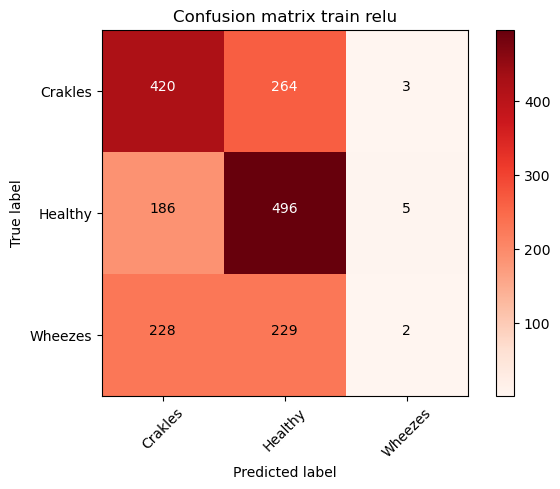

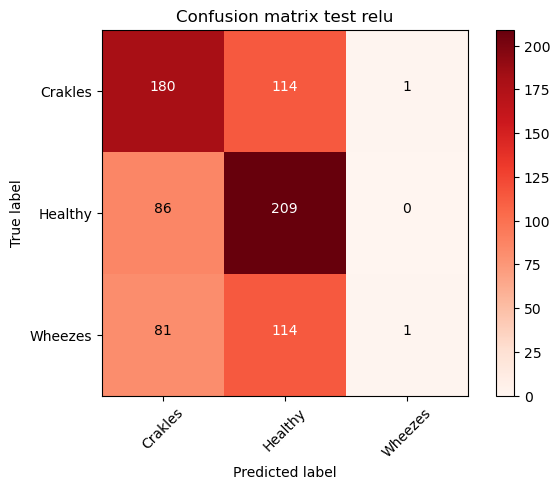

In [118]:
print("Best Parameters:", best_params)
print("Best Score:", best_score)
#Se crea la mejor red neuronal posible con los parametros anteriores
the_bestest=MLPClassifier(hidden_layer_sizes=best_params["hidden_layer_sizes"], activation=best.activation, solver='adam', max_iter=10000) 
metrics(the_bestest,Xtv,ytv,Xts,yts,['Crakles',"Healthy",'Wheezes'])

## K means

In [59]:
from sklearn import svm

clf = svm.NuSVC(gamma='auto')
clf.fit(Xtv,ytv)

predict_train = clf.predict(Xtv)
predict_test = clf.predict(Xts)

target_names = ["Healthy",'Crakles','Wheezes']
print(classification_report(ytv,predict_train,target_names=target_names))

print(classification_report(yts,predict_test,target_names=target_names))

ValueError: specified nu is infeasible